### 1-1,结构化数据建模流程范例

### 一，准备数据


titanic数据集的目标是根据乘客信息预测他们在Titanic号撞击冰山沉没后能否生存。

结构化数据一般会使用Pandas中的DataFrame进行预处理。

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import models, layers

In [3]:
# read data
dftrain_raw = pd.read_csv('../data/titanic/train.csv')
dftest_raw = pd.read_csv('../data/titanic/test.csv')
dftrain_raw.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,493,0,1,"Molson, Mr. Harry Markland",male,55.0,0,0,113787,30.5000,C30,S
1,53,1,1,"Harper, Mrs. Henry Sleeper (Myna Haxtun)",female,49.0,1,0,PC 17572,76.7292,D33,C
2,388,1,2,"Buss, Miss. Kate",female,36.0,0,0,27849,13.0000,NaN,S
3,192,0,2,"Carbines, Mr. William",male,19.0,0,0,28424,13.0000,NaN,S
4,687,0,3,"Panula, Mr. Jaako Arnold",male,14.0,4,1,3101295,39.6875,NaN,S
5,16,1,2,"Hewlett, Mrs. (Mary D Kingcome)",female,55.0,0,0,248706,16.0000,NaN,S
6,228,0,3,"Lovell, Mr. John Hall (""Henry"")",male,20.5,0,0,A/5 21173,7.2500,NaN,S
7,884,0,2,"Banfield, Mr. Frederick James",male,28.0,0,0,C.A./SOTON 34068,10.5000,NaN,S
8,168,0,3,"Skoog, Mrs. William (Anna Bernhardina Karlsson)",female,45.0,1,4,347088,27.9000,NaN,S
9,752,1,3,"Moor, Master. Meier",male,6.0,0,1,392096,12.4750,E121,S


字段说明：

* Survived:0代表死亡，1代表存活【y标签】
* Pclass:乘客所持票类，有三种值(1,2,3) 【转换成onehot编码】
* Name:乘客姓名 【舍去】
* Sex:乘客性别 【转换成bool特征】
* Age:乘客年龄(有缺失) 【数值特征，添加“年龄是否缺失”作为辅助特征】
* SibSp:乘客兄弟姐妹/配偶的个数(整数值) 【数值特征】
* Parch:乘客父母/孩子的个数(整数值)【数值特征】
* Ticket:票号(字符串)【舍去】
* Fare:乘客所持票的价格(浮点数，0-500不等) 【数值特征】
* Cabin:乘客所在船舱(有缺失) 【添加“所在船舱是否缺失”作为辅助特征】
* Embarked:乘客登船港口:S、C、Q(有缺失)【转换成onehot编码，四维度 S,C,Q,nan】

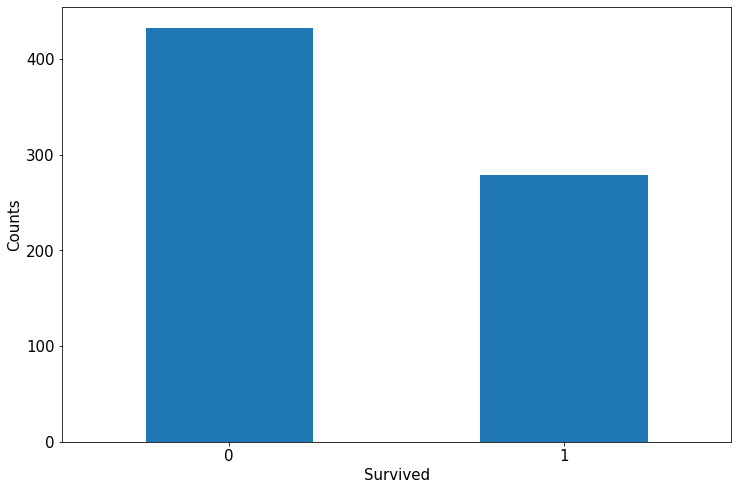

In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
ax = dftrain_raw['Survived'].value_counts().plot(kind = 'bar',
     figsize = (12,8),fontsize=15,rot = 0)
ax.set_ylabel('Counts',fontsize = 15)
ax.set_xlabel('Survived',fontsize = 15)
plt.show()

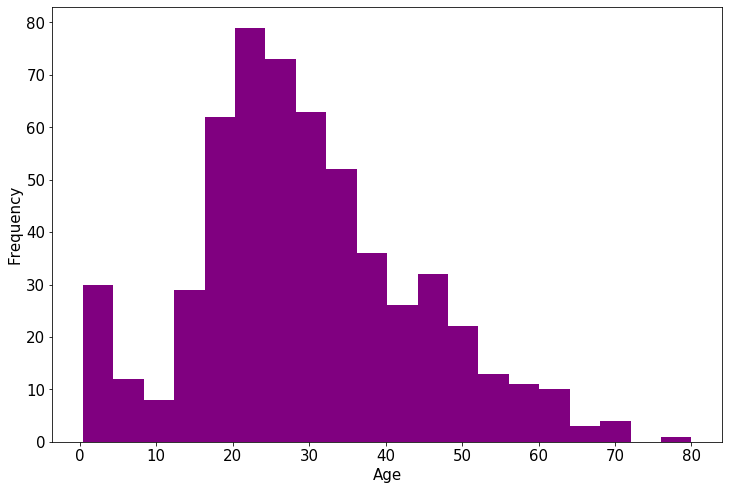

In [5]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
ax = dftrain_raw['Age'].plot(kind = 'hist',bins = 20,color= 'purple',
                    figsize = (12,8),fontsize=15)

ax.set_ylabel('Frequency',fontsize = 15)
ax.set_xlabel('Age',fontsize = 15)
plt.show()

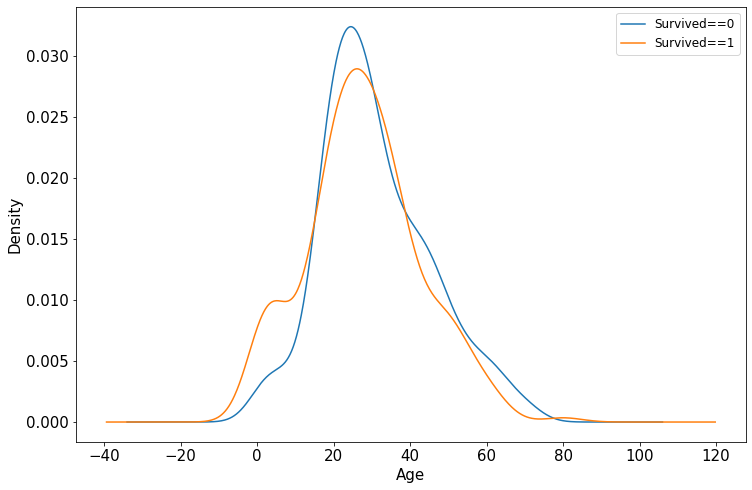

In [5]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
ax = dftrain_raw.query('Survived == 0')['Age'].plot(kind = 'density',
                      figsize = (12,8),fontsize=15)
dftrain_raw.query('Survived == 1')['Age'].plot(kind = 'density',
                      figsize = (12,8),fontsize=15)
ax.legend(['Survived==0','Survived==1'],fontsize = 12)
ax.set_ylabel('Density',fontsize = 15)
ax.set_xlabel('Age',fontsize = 15)
plt.show()

In [6]:
def preprocessing(dfdata):
    dfresult= pd.DataFrame()
    #Pclass
    dfPclass = pd.get_dummies(dfdata['Pclass'])
    dfPclass.columns = ['Pclass_' +str(x) for x in dfPclass.columns ]
    dfresult = pd.concat([dfresult,dfPclass],axis = 1)
    
    #Sex
    dfSex = pd.get_dummies(dfdata['Sex'])
    dfresult = pd.concat([dfresult,dfSex],axis = 1)
    
    #Age
    dfresult['Age'] = dfdata['Age'].fillna(0)
    dfresult['Age_null'] = pd.isna(dfdata['Age']).astype('int32')

    #SibSp,Parch,Fare
    dfresult['SibSp'] = dfdata['SibSp']
    dfresult['Parch'] = dfdata['Parch']
    dfresult['Fare'] = dfdata['Fare']
    
    #Carbin
    dfresult['Cabin_null'] =  pd.isna(dfdata['Cabin']).astype('int32')

    #Embarked
    dfEmbarked = pd.get_dummies(dfdata['Embarked'],dummy_na=True)
    dfEmbarked.columns = ['Embarked_' + str(x) for x in dfEmbarked.columns]
    dfresult = pd.concat([dfresult,dfEmbarked],axis = 1)

    return(dfresult)

In [7]:
x_train = preprocessing(dftrain_raw)
y_train = dftrain_raw['Survived'].values
x_test = preprocessing(dftest_raw)
y_test = dftest_raw['Survived'].values
print("x_train.shape =", x_train.shape )
print("x_test.shape =", x_test.shape )
x_train.head()

x_train.shape = (712, 15)
x_test.shape = (179, 15)


,Pclass_1,Pclass_2,Pclass_3,female,male,Age,Age_null,SibSp,Parch,Fare,Cabin_null,Embarked_C,Embarked_Q,Embarked_S,Embarked_nan
0,1,0,0,0,1,55.0,0,0,0,30.5000,0,0,0,1,0
1,1,0,0,1,0,49.0,0,1,0,76.7292,0,1,0,0,0
2,0,1,0,1,0,36.0,0,0,0,13.0000,1,0,0,1,0
3,0,1,0,0,1,19.0,0,0,0,13.0000,1,0,0,1,0
4,0,0,1,0,1,14.0,0,4,1,39.6875,1,0,0,1,0


In [9]:
#构建模型
model = models.Sequential()
model = models.Sequential()
model.add(layers.Dense(20,activation = 'relu',input_shape=(15,)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(10,activation = 'relu' ))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1,activation = 'sigmoid' ))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 20)                320       
_________________________________________________________________
dropout (Dropout)            (None, 20)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                210       
_________________________________________________________________
dropout_1 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 11        
Total params: 541
Trainable params: 541
Non-trainable params: 0
_________________________________________________________________


In [10]:
model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['AUC', 'accuracy'])

In [11]:
history = model.fit(x_train, y_train, batch_size=100, epochs=30, validation_split=0.2)

W0411 11:01:26.868108 4632960448 training.py:504] Falling back from v2 loop because of error: Failed to find data adapter that can handle input: <class 'pandas.core.frame.DataFrame'>, <class 'NoneType'>


Train on 569 samples, validate on 143 samples
Epoch 1/30
569/569 [==============================] - 1s 1ms/sample - loss: 3.6583 - AUC: 0.5405 - accuracy: 0.5659 - val_loss: 4.2531 - val_AUC: 0.4688 - val_accuracy: 0.5874
Epoch 2/30
569/569 [==============================] - 0s 47us/sample - loss: 3.8909 - AUC: 0.5183 - accuracy: 0.5677 - val_loss: 4.2232 - val_AUC: 0.4760 - val_accuracy: 0.5874
Epoch 3/30
569/569 [==============================] - 0s 101us/sample - loss: 3.8504 - AUC: 0.5050 - accuracy: 0.5641 - val_loss: 4.1710 - val_AUC: 0.4760 - val_accuracy: 0.5874
Epoch 4/30
569/569 [==============================] - 0s 62us/sample - loss: 3.8335 - AUC: 0.4953 - accuracy: 0.5624 - val_loss: 4.0889 - val_AUC: 0.4796 - val_accuracy: 0.5874
Epoch 5/30
569/569 [==============================] - 0s 72us/sample - loss: 3.4224 - AUC: 0.5005 - accuracy: 0.5501 - val_loss: 3.9998 - val_AUC: 0.4791 - val_accuracy: 0.5874
Epoch 6/30
569/569 [==============================] - 0s 101us/sample

In [24]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

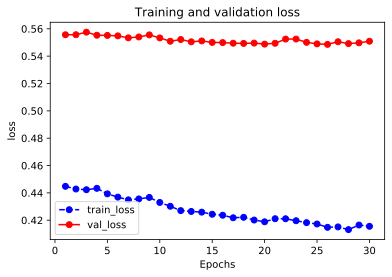

In [25]:
plot_metric(history,"loss")

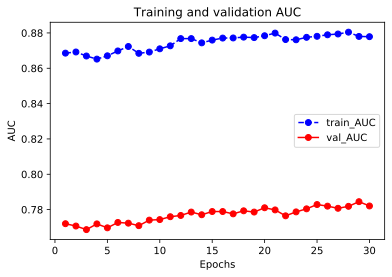

In [26]:
plot_metric(history,"AUC")

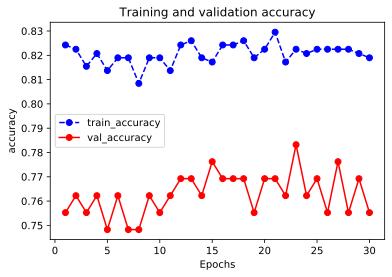

In [27]:
plot_metric(history,"accuracy")

In [28]:
model.evaluate(x = x_test,y = y_test)

W0409 17:07:58.945502 4544196032 training.py:504] Falling back from v2 loop because of error: Failed to find data adapter that can handle input: <class 'pandas.core.frame.DataFrame'>, <class 'NoneType'>


179/179 [==============================] - 0s 77us/sample - loss: 0.4507 - AUC: 0.8464 - accuracy: 0.7877


[0.45071740473448896, 0.8464012, 0.7877095]

In [31]:
#预测概率
model.predict(x_test[0:10])
#model(tf.constant(x_test[0:10].values,dtype = tf.float32)) #等价写法

W0409 17:09:11.118810 4544196032 training.py:504] Falling back from v2 loop because of error: Failed to find data adapter that can handle input: <class 'pandas.core.frame.DataFrame'>, <class 'NoneType'>


array([[0.27439672],
       [0.55657077],
       [0.47582024],
       [0.96164453],
       [0.7311535 ],
       [0.783311  ],
       [0.05770749],
       [0.8886502 ],
       [0.3151182 ],
       [0.13125311]], dtype=float32)

In [30]:
model.predict_classes(x_test[0:10])

W0409 17:08:25.748863 4544196032 training.py:504] Falling back from v2 loop because of error: Failed to find data adapter that can handle input: <class 'pandas.core.frame.DataFrame'>, <class 'NoneType'>


array([[0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0]], dtype=int32)

In [32]:
model.save('./keras_model.h5')
del model 

In [33]:
model = models.load_model('./keras_model.h5')
model.evaluate(x_test,y_test)

W0409 17:09:29.206138 4544196032 training.py:504] Falling back from v2 loop because of error: Failed to find data adapter that can handle input: <class 'pandas.core.frame.DataFrame'>, <class 'NoneType'>


179/179 [==============================] - 0s 422us/sample - loss: 0.4507 - AUC: 0.8464 - accuracy: 0.7877


[0.45071740473448896, 0.8464012, 0.7877095]

In [34]:
# 保存模型结构
json_str = model.to_json()

# 恢复模型结构
model_json = models.model_from_json(json_str)

In [35]:
print(model_json)

In [36]:
#保存模型权重
model.save_weights('./keras_model_weight.h5')

In [37]:
# 恢复模型结构
model_json = models.model_from_json(json_str)
model_json.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['AUC']
    )

In [38]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 20)                320       
_________________________________________________________________
dense_3 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 11        
Total params: 541
Trainable params: 541
Non-trainable params: 0
_________________________________________________________________


In [39]:
# 加载权重
model_json.load_weights('./keras_model_weight.h5')

In [40]:
model_json.evaluate(x_test, y_test)

W0409 17:10:57.352519 4544196032 training.py:504] Falling back from v2 loop because of error: Failed to find data adapter that can handle input: <class 'pandas.core.frame.DataFrame'>, <class 'NoneType'>


179/179 [==============================] - 0s 980us/sample - loss: 0.4507 - AUC: 0.8464


[0.45071740473448896, 0.8464012]

In [41]:
model.save_weights('./tf_model_weights.ckpt',save_format = "tf")

In [42]:
model.save('./tf_model_savedmodel', save_format="tf")

W0409 17:11:47.205037 4544196032 deprecation.py:506] From /Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1781: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [43]:
print('export saved model.')

export saved model.


In [44]:
model_loaded = tf.keras.models.load_model('./tf_model_savedmodel')

In [45]:
model_loaded.evaluate(x_test,y_test)

W0409 17:12:11.295898 4544196032 training.py:504] Falling back from v2 loop because of error: Failed to find data adapter that can handle input: <class 'pandas.core.frame.DataFrame'>, <class 'NoneType'>


179/179 [==============================] - 0s 711us/sample - loss: 0.4507 - AUC: 0.8464 - accuracy: 0.7877


[0.45071740473448896, 0.8464012, 0.7877095]

In [ ]:
model_loaded1 = tf.keras.models.load_model('')